#### Anthony Wilson 
#### Milestone 3
#### 5/5/2020


In [271]:
import pandas as pd
import regex as re
import numpy as np
from bs4 import BeautifulSoup
from multiprocessing import Pool
import urllib3
import requests
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import string

In [2]:
# we need to pull in all the country data from the api
def getCovidApiData(get = 'all'):
    url = 'https://covid-api.com/'
    resp = requests.get(url + get)
    df = pd.DataFrame(resp.json())
    return df   

In [3]:
#creating dataset for api
covidapi = getCovidApiData()
covidapi.head()

,Country,CountryCode,Province,City,CityCode,Lat,Lon,Confirmed,Deaths,Recovered,Active,Date
0,Afghanistan,AF,,,,33.94,67.71,0,0,0,0,2020-01-22T00:00:00Z
1,Afghanistan,AF,,,,33.94,67.71,0,0,0,0,2020-01-23T00:00:00Z
2,Afghanistan,AF,,,,33.94,67.71,0,0,0,0,2020-01-24T00:00:00Z
3,Afghanistan,AF,,,,33.94,67.71,0,0,0,0,2020-01-25T00:00:00Z
4,Afghanistan,AF,,,,33.94,67.71,0,0,0,0,2020-01-26T00:00:00Z


In [4]:
# we are going to webscrape google
# urlGoogleGenerator generates a url for the country and then 'covid 19'
def urlGoogleGenerator(data):
    apiCountryDict = {}
    for i in data.Country.unique():
        # creating the url search for each country
        # I need to find a string translator, but for the mean time this worked
        # the weird string caused an error with the function
        if i == "Côte d'Ivoire": 
            url = 'news.google.com/search?for={}%20covid%2019&hl=en-US&gl=US&ceid=US%3Aen'.format("Cote d'Ivoire")
        else:
            url = 'news.google.com/search?for={}%20covid%2019&hl=en-US&gl=US&ceid=US%3Aen'.format(i)
        #spaces are not handled well in an html address, updating to %20
        url = re.sub('\s', '%20', url) #translating spaces to the url language
        url = re.sub('\'', '%27', url) #translating tick marks to the url language
        apiCountryDict.update({i : url})
    return apiCountryDict

In [5]:
# creating google data frame
googCountries = urlGoogleGenerator(covidapi)
df_gc = pd.DataFrame(googCountries.items(), columns = ['country','google_country_url'])
df_gc.head(10)

,country,google_country_url
0,Afghanistan,news.google.com/search?for=Afghanistan%20covid...
1,Albania,news.google.com/search?for=Albania%20covid%201...
2,Algeria,news.google.com/search?for=Algeria%20covid%201...
3,Andorra,news.google.com/search?for=Andorra%20covid%201...
4,Angola,news.google.com/search?for=Angola%20covid%2019...
5,Antigua and Barbuda,news.google.com/search?for=Antigua%20and%20Bar...
6,Argentina,news.google.com/search?for=Argentina%20covid%2...
7,Armenia,news.google.com/search?for=Armenia%20covid%201...
8,Australia,news.google.com/search?for=Australia%20covid%2...
9,Austria,news.google.com/search?for=Austria%20covid%201...


In [6]:
# getWebsiteData is pulling the actual search results dumping them into soup and returning it
def getWebsiteData(url):
    http = urllib3.PoolManager()
    try:
        url = http.request('GET', url, timeout = 2.5) # this took forever to run setting time limit
        soup = BeautifulSoup(url.data)
        url.close()
        return soup
    except:
        return 'N/A'
# extractString uses regular expression to extract a pattern of strings out
def extractString(placeholder, pattern):
    
    p = re.compile(pattern)
    try:
        a = p.search(placeholder)
    except:
        a = ''
    return a
# getURL_Title pulls the title of the article and the web address
def getURL_Title(placeholder):
    m_group = extractString(str(placeholder),'(href=\")(\S{1,}\")(>)(.*)(<\/a>)')
    url = re.sub('^\.', 'news.google.com', re.sub('\"', '', m_group[2]))
    return {m_group[4]: url}

# createWebDict creates a dictionary for the country and all of its news articles found on google news
def createWebDict(url):
    webDict = {}
    soup = getWebsiteData(url)
    _list_ = soup.findAll('h3')
   
    for i in _list_:
        webDict.update(getURL_Title(i))
        
    return webDict

In [7]:
# getCountryURLs pulls the dictionary created from createWebDict and creates a dataframe
def getCountryURLs(country, googleurl):
    
    webDict = {}
    df = []
    webDict = createWebDict(googleurl) 
    df = pd.DataFrame(webDict.items(), columns = ['title','URL'])
    df['country'] = country
    return df[['country','title','URL']]
# createWebScrapeDF calls the functions to search google, pulls news articles for the country search
def createWebScrapeDF(data):
    df= []
    ii = 0 # counter to identify how far along we are
    n = len(data) # total number to google
    for i in range(len(data.country)):
        clear_output(wait=True) # update bar used to clear out output and refresh progress
        print('{} - {} % complete'.format(ii, ii/n * 100)) # calculating percent completed
        df.append(getCountryURLs(data.country[i],data.google_country_url[i]))
        ii += 1
    # pull all the data together
    df = pd.concat(df,axis = 0, ignore_index = True)
    return df

In [8]:
#disable warnings, for now so it doesn't clutter up the output
urllib3.disable_warnings()
web_df = createWebScrapeDF(df_gc)
web_df.head(10)

184 - 99.45945945945947 % complete


,country,title,URL
0,Afghanistan,Afghanistan's COVID-19 positive cases rise to ...,news.google.com/articles/CBMiO2h0dHA6Ly93d3cue...
1,Afghanistan,Afghanistan needs a ceasefire now to battle CO...,news.google.com/articles/CBMia2h0dHBzOi8vd3d3L...
2,Afghanistan,"Civil war, poverty and now the virus: Afghanis...",news.google.com/articles/CBMiY2h0dHBzOi8vd3d3L...
3,Afghanistan,Afghans brace for COVID-19 outbreak,news.google.com/articles/CBMiW2h0dHBzOi8vd3d3L...
4,Afghanistan,"Afghanistan reports 190 new COVID-19 cases, ta...",news.google.com/articles/CBMiO2h0dHA6Ly93d3cue...
5,Afghanistan,Afghans face Ramadan under shadow of COVID-19,news.google.com/articles/CAIiEPJV0mV_vdNWjLi2-...
6,Afghanistan,"To fight COVID-19 in Afghanistan, AHMADZAI say...",news.google.com/articles/CAIiENfyalk-0QGBoyGrE...
7,Afghanistan,Afghans concerned about income amid COVID-19 l...,news.google.com/articles/CBMiZmh0dHBzOi8vd3d3L...
8,Afghanistan,Trump tells advisers U.S. should pull troops a...,news.google.com/articles/CAIiEBsTG77rZD2SMHxf-...
9,Afghanistan,"As Migrants Flee Iran's Outbreak, Afghanistan ...",news.google.com/articles/CBMifmh0dHBzOi8vd3d3L...


In [9]:
# since google gives us a unique url that gets redirected when clicked, I am going to rename the column
# and pull the correct url for the website
web_df = web_df.rename(columns = {'URL': 'google_url'})
web_df.head(10)

,country,title,google_url
0,Afghanistan,Afghanistan's COVID-19 positive cases rise to ...,news.google.com/articles/CBMiO2h0dHA6Ly93d3cue...
1,Afghanistan,Afghanistan needs a ceasefire now to battle CO...,news.google.com/articles/CBMia2h0dHBzOi8vd3d3L...
2,Afghanistan,"Civil war, poverty and now the virus: Afghanis...",news.google.com/articles/CBMiY2h0dHBzOi8vd3d3L...
3,Afghanistan,Afghans brace for COVID-19 outbreak,news.google.com/articles/CBMiW2h0dHBzOi8vd3d3L...
4,Afghanistan,"Afghanistan reports 190 new COVID-19 cases, ta...",news.google.com/articles/CBMiO2h0dHA6Ly93d3cue...
5,Afghanistan,Afghans face Ramadan under shadow of COVID-19,news.google.com/articles/CAIiEPJV0mV_vdNWjLi2-...
6,Afghanistan,"To fight COVID-19 in Afghanistan, AHMADZAI say...",news.google.com/articles/CAIiENfyalk-0QGBoyGrE...
7,Afghanistan,Afghans concerned about income amid COVID-19 l...,news.google.com/articles/CBMiZmh0dHBzOi8vd3d3L...
8,Afghanistan,Trump tells advisers U.S. should pull troops a...,news.google.com/articles/CAIiEBsTG77rZD2SMHxf-...
9,Afghanistan,"As Migrants Flee Iran's Outbreak, Afghanistan ...",news.google.com/articles/CBMifmh0dHBzOi8vd3d3L...


In [10]:
# each country was returning ~75-100 news articles and it was taking a long time to webscrape
# cutting it to 10 news articles per country
def top5articles(data, n=10, column = 'title'):
    return data.sort_values(by = column)[-n:]
web_df_2 = web_df.groupby('country').apply(top5articles)

In [11]:
# getRedirectUrl takes the google url and finds the redirected url
def getRedirectUrl(url):
    try:
        soup = getWebsiteData(url) # calling google url
        tag = soup.find('noscript') # pull unqiue tag for the redirect url 
        m_group = extractString(str(tag),'(href=\")(\S{1,}\")') # get rid of fluff surrounding url
        url_u = re.sub('\"', '', m_group[2]) 
        return url, url_u,
    except:
        return url,"N/A"
    

In [12]:
# listRedirectUrl loops through url lists and returns the redirected url list
# note this takes about 5- 6 hours to run
def listRedirectUrl(data):
    _list_ = []
    # counter like previous function for progress 
    i = 0 
    n = len(data)
    for url in data:
        _list_.append(getRedirectUrl(url))
        clear_output(wait=True)
        print('{} - {} % complete'.format(i, i/n * 100))
        i += 1
    return _list_

In [13]:
web_df_2['read_Url'] = listRedirectUrl(web_df_2['google_url'])

1839 - 99.94565217391305 % complete


In [ ]:
# creating new columns
web_df_3['read_Url'] = createupdate(web_df_3.read_Url) 
web_df_3.head(10)

In [22]:
# createupdate splits up the list within read_Url to only use the actual web address
# once I realized I did this, it was to late to fix, this was the quicker solution rather than rerun
def createupdate(data):
    _list_ = []
    for i in range(len(data)):
        _list_.append(data[i][1])
    return _list_

In [45]:
# getting rid of the index and so there is just one country column
web_df_3= web_df_2.drop(['country'], axis = 1).reset_index()
web_df_3 = web_df_3.drop(['level_1'], axis = 1)
web_df_3['read_Url'] = createupdate(web_df_3['read_Url'])
web_df_3.head(12)


,country,title,google_url,read_Url
0,Afghanistan,"To fight COVID-19 in Afghanistan, AHMADZAI say...",news.google.com/articles/CAIiENfyalk-0QGBoyGrE...,https://www.globenewswire.com/news-release/202...
1,Afghanistan,Troy COVID-19 patient says clinical trial of r...,news.google.com/articles/CBMiaWh0dHA6Ly9kYXl0b...,http://dayton247now.com/news/coronavirus/troy-...
2,Afghanistan,Trump and Pakistan's Khan Discuss Coordination...,news.google.com/articles/CBMiZGh0dHBzOi8vd3d3L...,https://www.nytimes.com/reuters/2020/04/22/wor...
3,Afghanistan,Trump tells advisers U.S. should pull troops a...,news.google.com/articles/CAIiEBsTG77rZD2SMHxf-...,https://indiagoneviral.com/worldnews/2020/04/2...
4,Afghanistan,"Trump, Pakistan PM Discuss Coordination On COV...",news.google.com/articles/CBMidGh0dHBzOi8vd3d3L...,https://www.kff.org/news-summary/trump-pakista...
5,Afghanistan,U.S. coronavirus deaths now surpass fatalities...,news.google.com/articles/CAIiEFcqNYEJHBpA8XFDh...,https://www.nationalgeographic.com/history/202...
6,Afghanistan,UNHCR Asia and the Pacific COVID-19 External U...,news.google.com/articles/CAIiEDVvI-zE0dyml1rJw...,https://reliefweb.int/report/afghanistan/unhcr...
7,Afghanistan,"Untested for Covid-19, Afghans flee home from ...",news.google.com/articles/CAIiEMR3J05MgOMigb0_4...,https://www.indiatoday.in/world/story/untested...
8,Afghanistan,What the COVID-19 Outbreak Means for Afghanist...,news.google.com/articles/CBMiY2h0dHBzOi8vdGhlZ...,https://thediplomat.com/2020/04/what-the-covid...
9,Afghanistan,You can help Afghanistan fight Covid-19 - Fran...,news.google.com/articles/CBMiXWh0dHBzOi8vYmxvZ...,https://blog.timesunion.com/frankrobinson/2020...


In [343]:
# the above took half the day to run so I am creating a back up 
import sqlite3
# we first need to create a table and define the columns and their variable types
query = """ 
            CREATE TABLE ggle_webscrape
            (
                country VARCHAR(100),
                title VARCHAR(300),
                google_url VARCHAR(300), 
                read_Url VARCHAR(300)
            );"""

In [344]:
# now we need to create our database or place to store the table
con = sqlite3.connect('dsc_540_project.sqlite') 
# commit, keeps the entire transaction, else it will be rolled back once we log out
con.execute(query)
# excecute the create table statement so we have a table set up
con.commit()


In [345]:
#insert statement, '?' are like the placeholders for the variables
stmt = "INSERT INTO ggle_webscrape VALUES(?,?,?,?)"
# normally in sql you would have the insert statemnt above and then the data below
# doing it like this tells sqlite to insert and then we have the values after the comma
con.executemany(stmt, web_df_3.values.tolist())
con.commit()

In [346]:
# creating sel * to see the data
cursor = con.execute('Select * from ggle_webscrape')
rows = cursor.fetchall()
rows

[('Afghanistan',
  'To fight COVID-19 in Afghanistan, AHMADZAI says Afghan people need a strong health system, contrary to failed policy for peace and war',
  'news.google.com/articles/CAIiENfyalk-0QGBoyGrEmgqWx8qMwgEKioIACIQQrm4wrRfaVTiY_by5KwsfyoUCAoiEEK5uMK0X2lU4mP28uSsLH8wh_HIBg?hl=en-US&amp;gl=US&amp;ceid=US%3Aen',
  'https://www.globenewswire.com/news-release/2020/04/25/2022041/0/en/To-fight-COVID-19-in-Afghanistan-AHMADZAI-says-Afghan-people-need-a-strong-health-system-contrary-to-failed-policy-for-peace-and-war.html'),
 ('Afghanistan',
  'Troy COVID-19 patient says clinical trial of rare drug saved her life',
  'news.google.com/articles/CBMiaWh0dHA6Ly9kYXl0b24yNDdub3cuY29tL25ld3MvY29yb25hdmlydXMvdHJveS1jb3ZpZC0xOS1wYXRpZW50LXNheXMtY2xpbmljYWwtdHJpYWwtb2YtcmFyZS1kcnVnLXNhdmVkLWhlctIBbmh0dHBzOi8vZGF5dG9uMjQ3bm93LmNvbS9hbXAvbmV3cy9jb3JvbmF2aXJ1cy90cm95LWNvdmlkLTE5LXBhdGllbnQtc2F5cy1jbGluaWNhbC10cmlhbC1vZi1yYXJlLWRydWctc2F2ZWQtaGVy?hl=en-US&amp;gl=US&amp;ceid=US%3Aen',
  'http://da

In [82]:
# The actual table I am creating is looking at the key words and counting each time they are used within the article
# I am wondering if certain things are reported if they have are relationship to the number of cases
# a country might have or recovery rate
# categories are as follows:

keywords = [
            # any word related to the corona virus
            ['virus',
            'coronavirus',
            'covid-19',
            'severe acute respiratory syndrome coronavirus 2 ',
            'novel coronavirus',
            'epidemic',
            'pandemic',
            'coronavirus symptoms',
            'what is coronavirus',
            'influenza'],
            # words related to a cure 
            ['cure',
            'vaccine',
            'treatment',
            'remedy',
            'treat',
            'immunization',
            'medicine',
            'antidote',
            'medication',
            'medicament',
            'thearapy',
            'healing',
            'put an end to',
            'remove',
            'counteract'],
            # words realated to death or people dying
            ['death',
            'dead',
            'deceased',
            'die',
            'terminated',
            'demise',
            'dying',
            'end',
            'passing',
            'expiry',
            'expiration'],
            # words related to counts whether increasing or decreasing
            ['cases',
            'count',
            'total',
            'instance',
            'occurrence',
            'occasion',
            'manifestation',
            'demonstration'],
            # words related to money, income,etc...
            [ 'money',
            'stimulus',
            'supplement',
            'income',
            'salary',
            'pay',
            'wages',
            'stipend',
            'revenue',
            'receipts',
            'takings',
            'profits',
            'loss',
            'gains',
            'proceeds',
            'turnover',
            'employment',
            'unemployment',
            'yield',
            'dividend',
            'interest',
            'rates',
            'means',
            'expenditure',
            'outgoings',
            'wealth',
            'poverty'],
            # words related to distancing and isolation
            # this pandemic has flipped the world upside down with being quarantined 
            ['social distancing',
            'congregate settings',
            'isolation',
            'quarantine',
            'community spread',
            'flattening the curve',
            'withdraw',
            'detach',
            'separate',
            'isolate',
            'detachment',
            'confinement',
            'seperation',
            'seclusion',
            'remote',
            'segregation',
            'distance', 
            'distancing'],
            # looking for demographic words
            ['demographic',
            'race',
            'rural',
            'population',
            'densely populated',
            'citizens',
            'public',
            'community',
            'society',
            'race',
            'residents',
            'people',
            'society',
            'natives',
            'country',
            'countryside'],
            # medical supplies seems to be an issue as well
            ['supplies',
            'supply',
            'medical supplies',
            'incubation',
            'stock',
            'store',
            'reserve',
            'reservoir',
            'stockpile',
            'heap',
            'mass',
            'equipment',
            'apparatus',
            'incubation',
            'incubatore',
            'respiroator',
            'mask',
            'beds',
            'hospital',
            'health care',
            'clinic',
            'infirmary',
            'sanitation',
            'swab',
            'test',
            'scrubs']

]
# I am sure this list could be expanded, but due to the nature of this project getting 
# an understanding, I think this will suffice

In [339]:
from Levenshtein import distance
#used fuzzy match to find issues with punctions, and element tags.Then used translate to drop punction
# so the match is more accurate
# found overlapping values with fuzzy match so left it at 0 
def scrapeWeb(url):
    try: 
        soup = getWebsiteData(url)
        p = soup.find_all('p') # only pulling paragraphs

        _dict_ = {}
        #looping through keyword list
        for i in range(len(keywords)):
            count = 0 #creating a count for each keyword grouping
            # looping through each paragraph element from soup
            for ii in range(len(p)):
                # lower case and split each paragraph into alist
                for iii in p[ii].get_text().lower().split():
                    # check each word to see if it is in the list
                    for iiii in keywords[i]:
                        # drop puntuction
                        u = iii.translate(str.maketrans('', '', string.punctuation))
                        # check to see if there is a match
                        if (distance(u, iiii) == 0):
                            count+=1
            # each keyword grouping gets its on counts
            _dict_.update({i : count})
        _dict_
        df = pd.DataFrame(_dict_.values(), index = ['virus', 'cure', 'death', 'cases', 'money', 'distance', 'demographic', 'supplies'])
    # if web request fails, set count values to NAN and move on 
    except:
        df = pd.DataFrame([np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN], index = ['virus', 'cure', 'death', 'cases', 'money', 'distance', 'demographic', 'supplies'])
    return df.T

# loopThroughUrls just loops through the urls provided to scrape them for the keywords and then returns a dataframe
def loopThroughUrls(data):
    _df_ = []
    # updated this to 1 so at the end it shows 100% instead of ~99.999%
    ii = 1
    n = len(data)
 
    for i in data.read_Url:
        clear_output(wait=True)
        print('{} - {} % complete'.format(ii, ii/n * 100))
        _df_.append(scrapeWeb(i))
        ii += 1
    
    _df_ = pd.concat(_df_, axis=0, ignore_index=True) 
     
    return _df_
    
    

In [340]:
web_df_3_counts = loopThroughUrls(web_df_3)

1840 - 100.0 % complete


In [341]:
web_df_3_counts.head(10)

,virus,cure,death,cases,money,distance,demographic,supplies
0,1.0,1.0,1.0,1.0,0.0,0.0,8.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,12.0,0.0,3.0,4.0,0.0,2.0,13.0,1.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,10.0,0.0,7.0,3.0,0.0,0.0,3.0,0.0
6,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
7,12.0,1.0,2.0,5.0,3.0,3.0,7.0,3.0
8,8.0,0.0,1.0,1.0,20.0,0.0,15.0,1.0
9,0.0,0.0,1.0,0.0,4.0,0.0,3.0,1.0


In [261]:
# joining the web scrape for keyword counts to the url data frame based on index
web_df_4 = web_df_3.join(web_df_3_counts)[['country', 'title', 'virus', 'cure', 'death', 'cases', 'money', 'distance', 'demographic', 'supplies', 'google_url', 'read_Url']]
web_df_4.head(10)

,country,title,virus,cure,death,cases,money,distance,demographic,supplies,google_url,read_Url
0,Afghanistan,"To fight COVID-19 in Afghanistan, AHMADZAI say...",2.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,news.google.com/articles/CAIiENfyalk-0QGBoyGrE...,https://www.globenewswire.com/news-release/202...
1,Afghanistan,Troy COVID-19 patient says clinical trial of r...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,news.google.com/articles/CBMiaWh0dHA6Ly9kYXl0b...,http://dayton247now.com/news/coronavirus/troy-...
2,Afghanistan,Trump and Pakistan's Khan Discuss Coordination...,7.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,news.google.com/articles/CBMiZGh0dHBzOi8vd3d3L...,https://www.nytimes.com/reuters/2020/04/22/wor...
3,Afghanistan,Trump tells advisers U.S. should pull troops a...,9.0,0.0,3.0,4.0,0.0,2.0,10.0,1.0,news.google.com/articles/CAIiEBsTG77rZD2SMHxf-...,https://indiagoneviral.com/worldnews/2020/04/2...
4,Afghanistan,"Trump, Pakistan PM Discuss Coordination On COV...",3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,news.google.com/articles/CBMidGh0dHBzOi8vd3d3L...,https://www.kff.org/news-summary/trump-pakista...
5,Afghanistan,U.S. coronavirus deaths now surpass fatalities...,12.0,0.0,5.0,3.0,0.0,0.0,1.0,0.0,news.google.com/articles/CAIiEFcqNYEJHBpA8XFDh...,https://www.nationalgeographic.com/history/202...
6,Afghanistan,UNHCR Asia and the Pacific COVID-19 External U...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,news.google.com/articles/CAIiEDVvI-zE0dyml1rJw...,https://reliefweb.int/report/afghanistan/unhcr...
7,Afghanistan,"Untested for Covid-19, Afghans flee home from ...",11.0,1.0,2.0,5.0,1.0,3.0,5.0,2.0,news.google.com/articles/CAIiEMR3J05MgOMigb0_4...,https://www.indiatoday.in/world/story/untested...
8,Afghanistan,What the COVID-19 Outbreak Means for Afghanist...,11.0,0.0,1.0,1.0,15.0,0.0,11.0,1.0,news.google.com/articles/CBMiY2h0dHBzOi8vdGhlZ...,https://thediplomat.com/2020/04/what-the-covid...
9,Afghanistan,You can help Afghanistan fight Covid-19 - Fran...,2.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,news.google.com/articles/CBMiXWh0dHBzOi8vYmxvZ...,https://blog.timesunion.com/frankrobinson/2020...


In [347]:
# creating backup, scrape seems to take about 30 -45 minutes
query2 = """ 
            CREATE TABLE webScrape_Counts
            (
                country VARCHAR(100),
                title VARCHAR(300),
                virus float, 
                cure float, 
                death float, 
                cases float, 
                money float, 
                distance float, 
                demographic float, 
                supplies float, 
                google_url VARCHAR(300), 
                read_Url VARCHAR(300)
            );"""

con.execute(query2)
# excecute the create table statement so we have a table set up
con.commit()

In [348]:
stmt = "INSERT INTO webScrape_Counts VALUES(?,?,?,?,?,?,?,?,?,?,?,?)"
# normally in sql you would have the insert statemnt above and then the data below
# doing it like this tells sqlite to insert and then we have the values after the comma
con.executemany(stmt, web_df_4.values.tolist())
con.commit()

In [349]:
# creating sel * to see the data
cursor = con.execute('Select * from webScrape_Counts')
rows = cursor.fetchall()
rows

[('Afghanistan',
  'To fight COVID-19 in Afghanistan, AHMADZAI says Afghan people need a strong health system, contrary to failed policy for peace and war',
  2.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  6.0,
  0.0,
  'news.google.com/articles/CAIiENfyalk-0QGBoyGrEmgqWx8qMwgEKioIACIQQrm4wrRfaVTiY_by5KwsfyoUCAoiEEK5uMK0X2lU4mP28uSsLH8wh_HIBg?hl=en-US&amp;gl=US&amp;ceid=US%3Aen',
  'https://www.globenewswire.com/news-release/2020/04/25/2022041/0/en/To-fight-COVID-19-in-Afghanistan-AHMADZAI-says-Afghan-people-need-a-strong-health-system-contrary-to-failed-policy-for-peace-and-war.html'),
 ('Afghanistan',
  'Troy COVID-19 patient says clinical trial of rare drug saved her life',
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  'news.google.com/articles/CBMiaWh0dHA6Ly9kYXl0b24yNDdub3cuY29tL25ld3MvY29yb25hdmlydXMvdHJveS1jb3ZpZC0xOS1wYXRpZW50LXNheXMtY2xpbmljYWwtdHJpYWwtb2YtcmFyZS1kcnVnLXNhdmVkLWhlctIBbmh0dHBzOi8vZGF5dG9uMjQ3bm93LmNvbS9hbXAvbmV3cy9jb3JvbmF2aXJ1cy90cm95LWNvdmlkLTE5LXBhdGl

#### Table created - following assignment
Replace headers- this was completed, when I pulled the data
Format data into a more readable format this was done while creating the table, but I will aggregate the data once I have checked for duplicates.

In [351]:
# Find duplicates
web_df_4[web_df_4.duplicated()]
# as expected, but I am wondering if there will be overlap on the read_Urls

,country,title,virus,cure,death,cases,money,distance,demographic,supplies,google_url,read_Url


In [379]:
total = len(web_df_4[web_df_4.read_Url.duplicated()])
distinct = len(web_df_4[web_df_4.read_Url.duplicated()].read_Url.value_counts())
print('There are {} duplicated urls and of those, there are {} distinct.'.format(total, distinct))

There are 345 duplicated urls and of those, there are 158 distinct.


In [380]:
web_df_4[web_df_4.read_Url.duplicated()].read_Url.value_counts()

https://www.voanews.com/science-health/coronavirus-outbreak/zimbabwes-government-says-herbal-treatment-ok-covid-19                             17
https://www.atlanticcouncil.org/blogs/africasource/using-google-reports-to-estimate-africas-response-to-covid-19-a-compilation-of-the-data/    15
https://www.voanews.com/covid-19-pandemic/voices-africa-challenges-covering-covid-19                                                           11
https://www.voanews.com/covid-19-pandemic/war-ravaged-yemen-running-out-time-covid-19                                                          10
https://www.voanews.com/science-health/coronavirus-outbreak/who-warns-covid-19-accelerating-africa                                             10
                                                                                                                                               ..
https://www.voanews.com/covid-19-pandemic/sweden-says-it-prepared-fight-covid-19-long-term                                  

In [356]:
# this was the top repeated url, the smaller countries, I would expec to have duplicates, so I will drop them for now
web_df_4[web_df_4.read_Url == 'https://www.voanews.com/science-health/coronavirus-outbreak/zimbabwes-government-says-herbal-treatment-ok-covid-19']

,country,title,virus,cure,death,cases,money,distance,demographic,supplies,google_url,read_Url
38,Andorra,Zimbabwe's Government Says Herbal Treatment OK...,5.0,11.0,2.0,0.0,1.0,0.0,2.0,1.0,news.google.com/articles/CAIiEOP_5OCP5eeGno69a...,https://www.voanews.com/science-health/coronav...
189,Benin,Zimbabwe's Government Says Herbal Treatment OK...,5.0,11.0,2.0,0.0,1.0,0.0,2.0,1.0,news.google.com/articles/CAIiEOP_5OCP5eeGno69a...,https://www.voanews.com/science-health/coronav...
208,Bolivia,Zimbabwe's Government Says Herbal Treatment OK...,5.0,11.0,2.0,0.0,1.0,0.0,2.0,1.0,news.google.com/articles/CAIiEOP_5OCP5eeGno69a...,https://www.voanews.com/science-health/coronav...
229,Botswana,Zimbabwe's Government Says Herbal Treatment OK...,5.0,11.0,2.0,0.0,1.0,0.0,2.0,1.0,news.google.com/articles/CAIiEOP_5OCP5eeGno69a...,https://www.voanews.com/science-health/coronav...
319,Cape Verde,Zimbabwe's Government Says Herbal Treatment OK...,5.0,11.0,2.0,0.0,1.0,0.0,2.0,1.0,news.google.com/articles/CAIiEOP_5OCP5eeGno69a...,https://www.voanews.com/science-health/coronav...
539,Equatorial Guinea,Zimbabwe's Government Says Herbal Treatment OK...,5.0,11.0,2.0,0.0,1.0,0.0,2.0,1.0,news.google.com/articles/CAIiEOP_5OCP5eeGno69a...,https://www.voanews.com/science-health/coronav...
549,Eritrea,Zimbabwe's Government Says Herbal Treatment OK...,5.0,11.0,2.0,0.0,1.0,0.0,2.0,1.0,news.google.com/articles/CAIiEOP_5OCP5eeGno69a...,https://www.voanews.com/science-health/coronav...
1007,Madagascar,Zimbabwe's Government Says Herbal Treatment OK...,5.0,11.0,2.0,0.0,1.0,0.0,2.0,1.0,news.google.com/articles/CAIiEOP_5OCP5eeGno69a...,https://www.voanews.com/science-health/coronav...
1078,Mauritius,Zimbabwe's Government Says Herbal Treatment OK...,5.0,11.0,2.0,0.0,1.0,0.0,2.0,1.0,news.google.com/articles/CAIiEOP_5OCP5eeGno69a...,https://www.voanews.com/science-health/coronav...
1098,Moldova,Zimbabwe's Government Says Herbal Treatment OK...,5.0,11.0,2.0,0.0,1.0,0.0,2.0,1.0,news.google.com/articles/CAIiEOP_5OCP5eeGno69a...,https://www.voanews.com/science-health/coronav...


In [383]:
web_df_5 = web_df_4[web_df_4.read_Url.duplicated() == False]
web_df_5.head()

,country,title,virus,cure,death,cases,money,distance,demographic,supplies,google_url,read_Url
0,Afghanistan,"To fight COVID-19 in Afghanistan, AHMADZAI say...",2.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,news.google.com/articles/CAIiENfyalk-0QGBoyGrE...,https://www.globenewswire.com/news-release/202...
1,Afghanistan,Troy COVID-19 patient says clinical trial of r...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,news.google.com/articles/CBMiaWh0dHA6Ly9kYXl0b...,http://dayton247now.com/news/coronavirus/troy-...
2,Afghanistan,Trump and Pakistan's Khan Discuss Coordination...,7.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,news.google.com/articles/CBMiZGh0dHBzOi8vd3d3L...,https://www.nytimes.com/reuters/2020/04/22/wor...
3,Afghanistan,Trump tells advisers U.S. should pull troops a...,9.0,0.0,3.0,4.0,0.0,2.0,10.0,1.0,news.google.com/articles/CAIiEBsTG77rZD2SMHxf-...,https://indiagoneviral.com/worldnews/2020/04/2...
4,Afghanistan,"Trump, Pakistan PM Discuss Coordination On COV...",3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,news.google.com/articles/CBMidGh0dHBzOi8vd3d3L...,https://www.kff.org/news-summary/trump-pakista...


In [384]:
# creating backup of updated webscrape
query2 = """ 
            CREATE TABLE webScrape_Counts_2
            (
                country VARCHAR(100),
                title VARCHAR(300),
                virus float, 
                cure float, 
                death float, 
                cases float, 
                money float, 
                distance float, 
                demographic float, 
                supplies float, 
                google_url VARCHAR(300), 
                read_Url VARCHAR(300)
            );"""

con.execute(query2)
# excecute the create table statement so we have a table set up
con.commit()
stmt = "INSERT INTO webScrape_Counts_2 VALUES(?,?,?,?,?,?,?,?,?,?,?,?)"
# normally in sql you would have the insert statemnt above and then the data below
# doing it like this tells sqlite to insert and then we have the values after the comma
con.executemany(stmt, web_df_5.values.tolist())
con.commit()

In [385]:
# creating sel * to see the data
cursor = con.execute('Select * from webScrape_Counts')
rows = cursor.fetchall()
rows

[('Afghanistan',
  'To fight COVID-19 in Afghanistan, AHMADZAI says Afghan people need a strong health system, contrary to failed policy for peace and war',
  2.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  6.0,
  0.0,
  'news.google.com/articles/CAIiENfyalk-0QGBoyGrEmgqWx8qMwgEKioIACIQQrm4wrRfaVTiY_by5KwsfyoUCAoiEEK5uMK0X2lU4mP28uSsLH8wh_HIBg?hl=en-US&amp;gl=US&amp;ceid=US%3Aen',
  'https://www.globenewswire.com/news-release/2020/04/25/2022041/0/en/To-fight-COVID-19-in-Afghanistan-AHMADZAI-says-Afghan-people-need-a-strong-health-system-contrary-to-failed-policy-for-peace-and-war.html'),
 ('Afghanistan',
  'Troy COVID-19 patient says clinical trial of rare drug saved her life',
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  'news.google.com/articles/CBMiaWh0dHA6Ly9kYXl0b24yNDdub3cuY29tL25ld3MvY29yb25hdmlydXMvdHJveS1jb3ZpZC0xOS1wYXRpZW50LXNheXMtY2xpbmljYWwtdHJpYWwtb2YtcmFyZS1kcnVnLXNhdmVkLWhlctIBbmh0dHBzOi8vZGF5dG9uMjQ3bm93LmNvbS9hbXAvbmV3cy9jb3JvbmF2aXJ1cy90cm95LWNvdmlkLTE5LXBhdGl

In [386]:
# Format data into a more readable format
# here I am summing up all the values and storing them into one table
cursor = con.execute("""
                        Select country, 
                            sum(virus)  virus , 
                            sum(cure)  cure , 
                            sum(death)  death , 
                            sum(cases)  cases , 
                            sum(money)  money , 
                            sum(distance)  distance, 
                            sum(demographic)  demographic , 
                            sum(supplies)  supplies 
                        from webScrape_Counts_2
                        group by 1
                    """)
rows = cursor.fetchall()
web_df_6 = pd.DataFrame(rows, columns = ['country', 'virus', 'cure', 'death', 'cases', 'money', 'distance', 'demographic', 'supplies'])
web_df_6.head(10)

,country,virus,cure,death,cases,money,distance,demographic,supplies
0,Afghanistan,58.0,1.0,12.0,16.0,19.0,5.0,37.0,5.0
1,Albania,75.0,13.0,4.0,20.0,11.0,9.0,36.0,18.0
2,Algeria,140.0,15.0,10.0,34.0,11.0,12.0,97.0,47.0
3,Andorra,49.0,13.0,9.0,22.0,9.0,4.0,26.0,11.0
4,Angola,50.0,1.0,8.0,21.0,8.0,10.0,57.0,18.0
5,Antigua and Barbuda,32.0,2.0,8.0,17.0,2.0,8.0,35.0,23.0
6,Argentina,65.0,3.0,7.0,20.0,55.0,12.0,59.0,14.0
7,Armenia,73.0,1.0,4.0,32.0,21.0,0.0,25.0,4.0
8,Australia,132.0,4.0,18.0,33.0,27.0,28.0,100.0,51.0
9,Austria,98.0,15.0,19.0,58.0,12.0,33.0,113.0,32.0


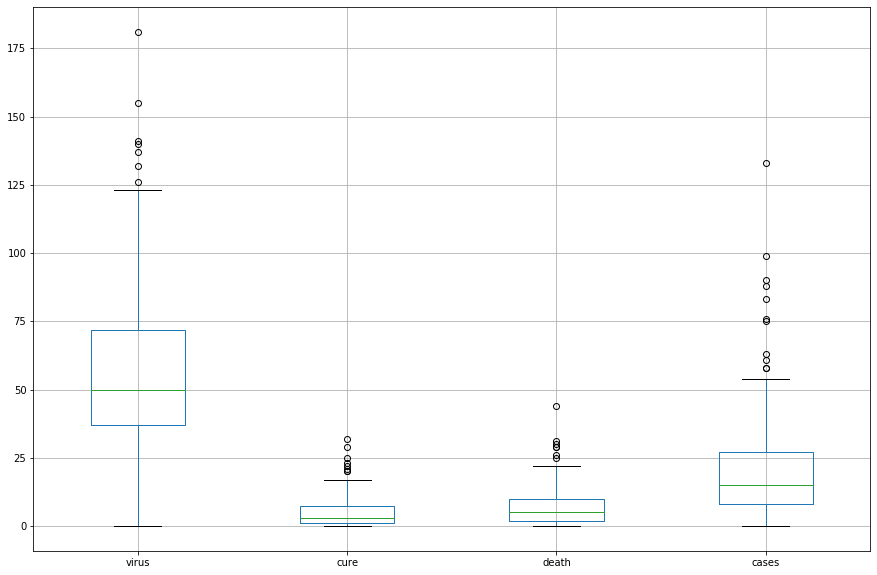

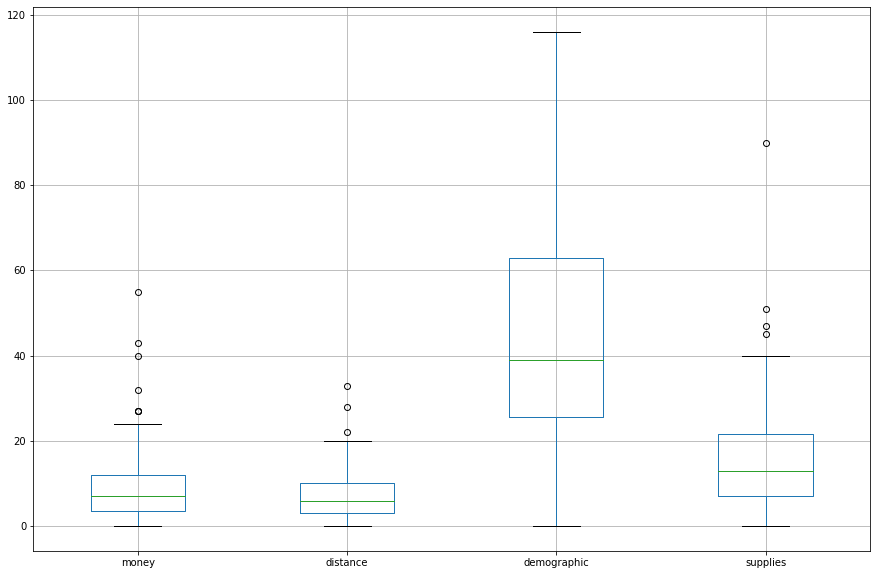

In [389]:
# Identify outliers and bad data
for i in range(1,len(web_df_6.columns),4):
    web_df_6[web_df_6.columns[i:i+4]].boxplot(figsize = (15,10), fontsize = 10)
    plt.show()

In [403]:
top_half = (web_df_6.virus > 125) | (web_df_6.cure > 20) | (web_df_6.death > 22) | (web_df_6.cases > 55) 
bottom_half = (web_df_6.money > 25) | (web_df_6.distance > 20) | (web_df_6.supplies > 40)
web_df_6[((top_half) | (bottom_half))]

,country,virus,cure,death,cases,money,distance,demographic,supplies
2,Algeria,140.0,15.0,10.0,34.0,11.0,12.0,97.0,47.0
6,Argentina,65.0,3.0,7.0,20.0,55.0,12.0,59.0,14.0
8,Australia,132.0,4.0,18.0,33.0,27.0,28.0,100.0,51.0
9,Austria,98.0,15.0,19.0,58.0,12.0,33.0,113.0,32.0
16,Belgium,123.0,4.0,31.0,34.0,22.0,16.0,86.0,20.0
17,Belize,86.0,5.0,2.0,133.0,8.0,6.0,84.0,28.0
24,Brunei Darussalam,181.0,13.0,2.0,58.0,22.0,9.0,45.0,26.0
28,Cambodia,89.0,2.0,10.0,26.0,1.0,9.0,61.0,45.0
34,Chile,96.0,5.0,7.0,29.0,43.0,10.0,90.0,16.0
38,Congo (Brazzaville),119.0,25.0,8.0,90.0,17.0,11.0,65.0,23.0


 I understand these might be outliers, but to drop countries like the US, Germany, and Francecould potentially have some issues. They are some of the main countries. For kicks, lets see what happens when we do drop them.

In [405]:
web_df_7 = web_df_6[((top_half) | (bottom_half)) == False]

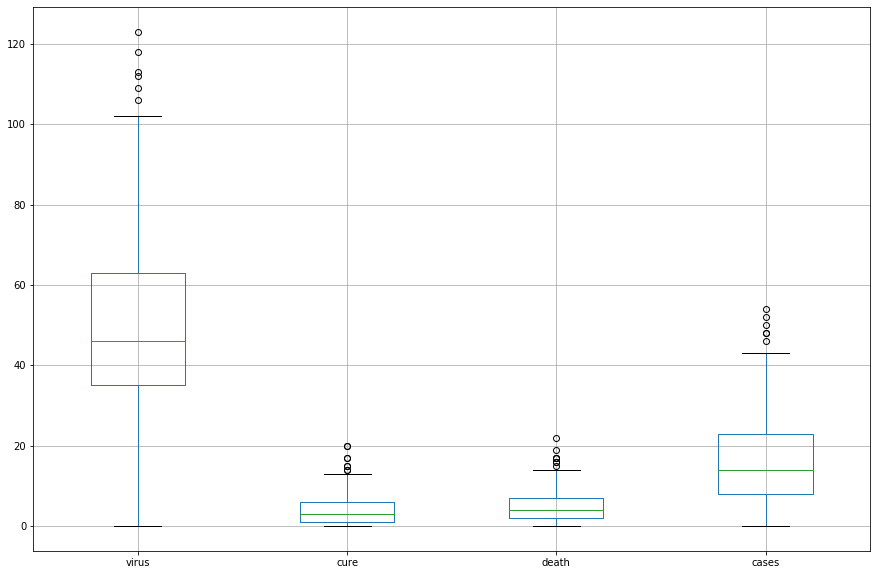

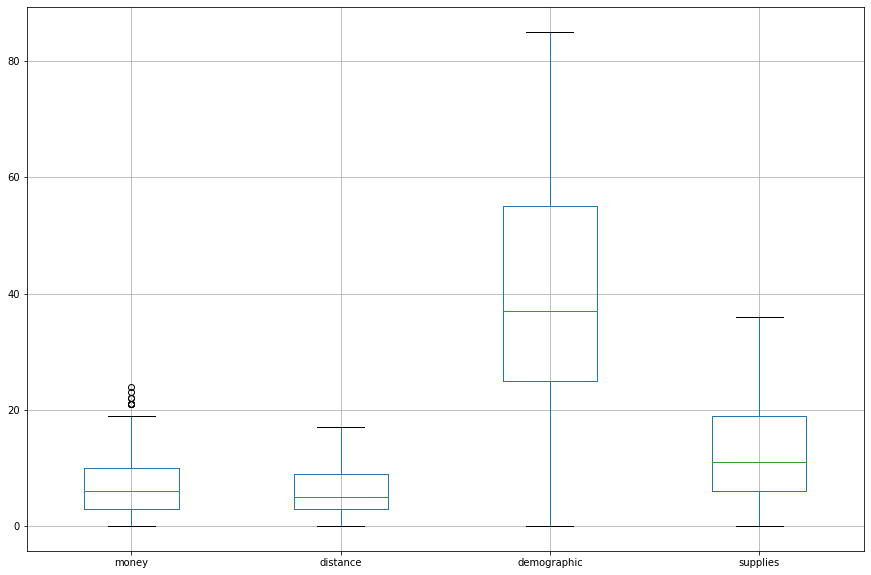

In [407]:
for i in range(1,len(web_df_7.columns),4):
    web_df_7[web_df_7.columns[i:i+4]].boxplot(figsize = (15,10), fontsize = 10)
    plt.show()

As I expected, we might keep widdling away at this until there is nothing left. 

I have created a data set from scraping the web. The key words could have been added to, everything that I had was based on the English language. So, there could be more done to complete this data. It ended up being a bigger feat than I imagined, by a long shot. I really enjoyed, and can better understand and appreciate the process. 